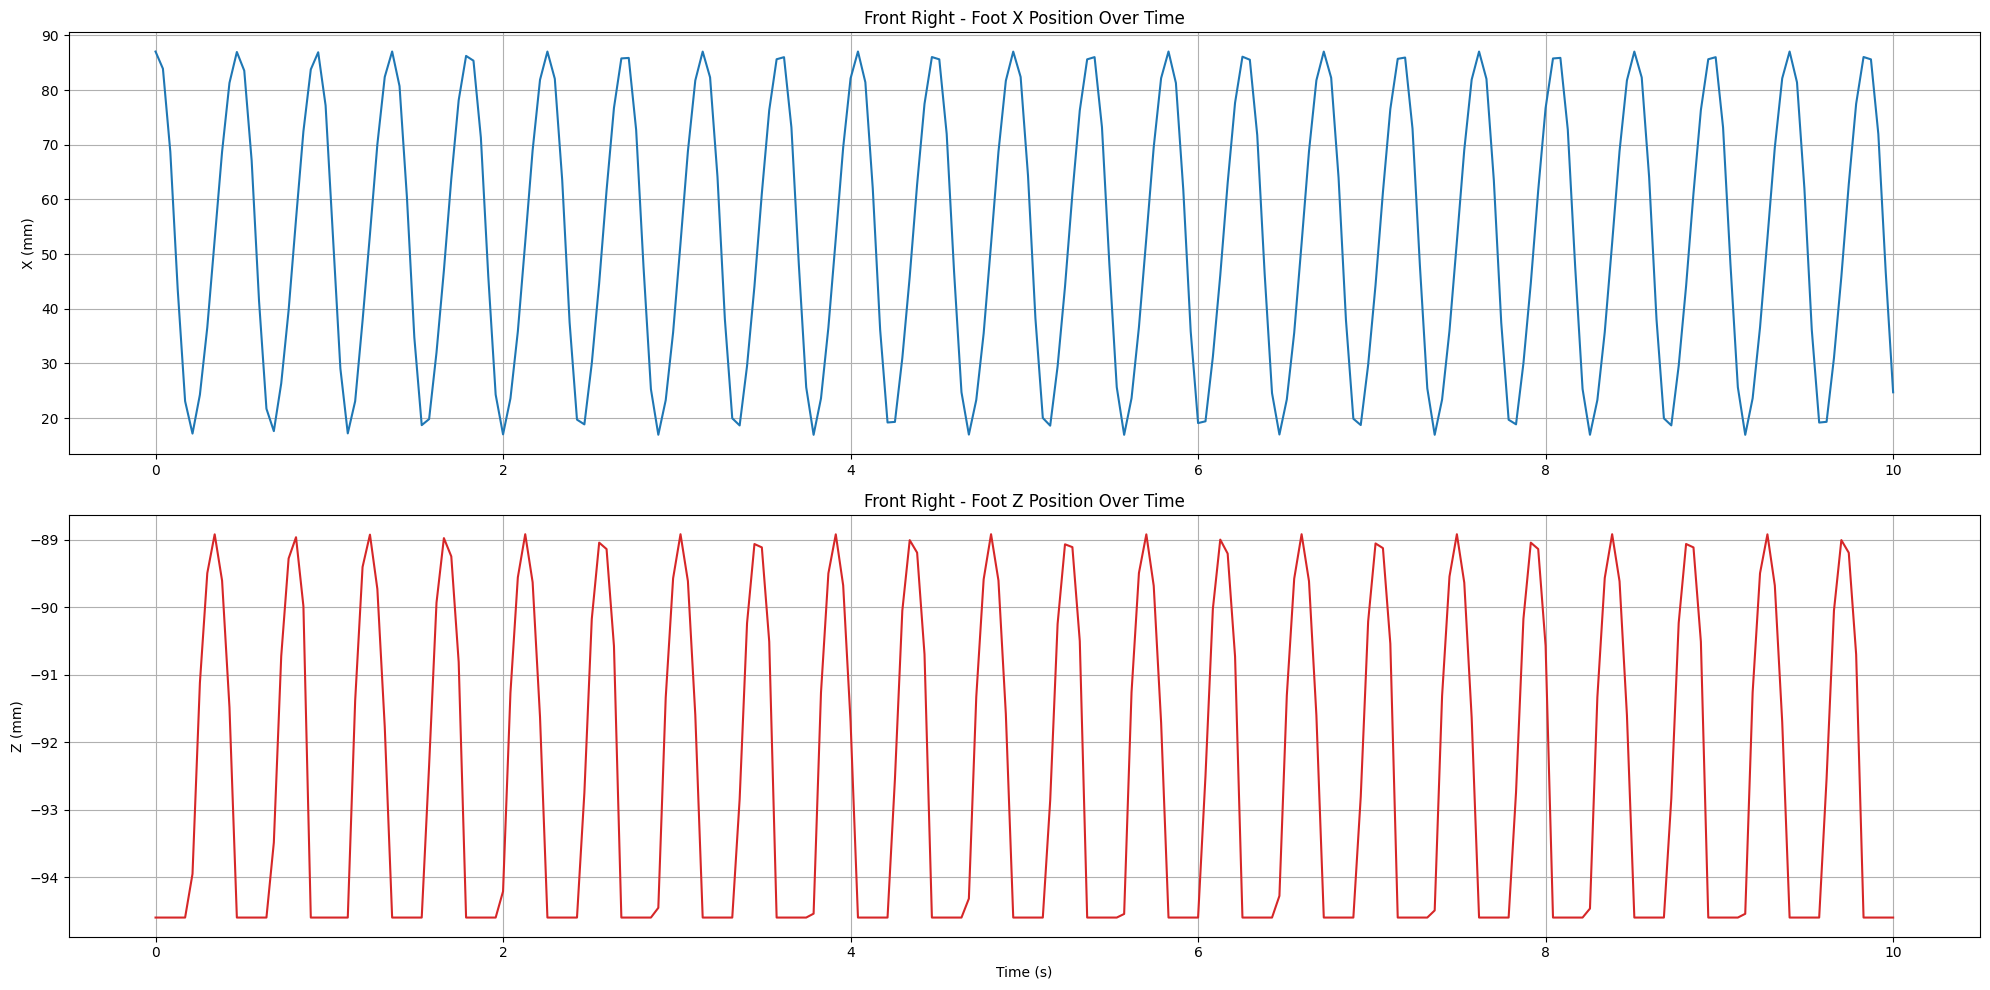

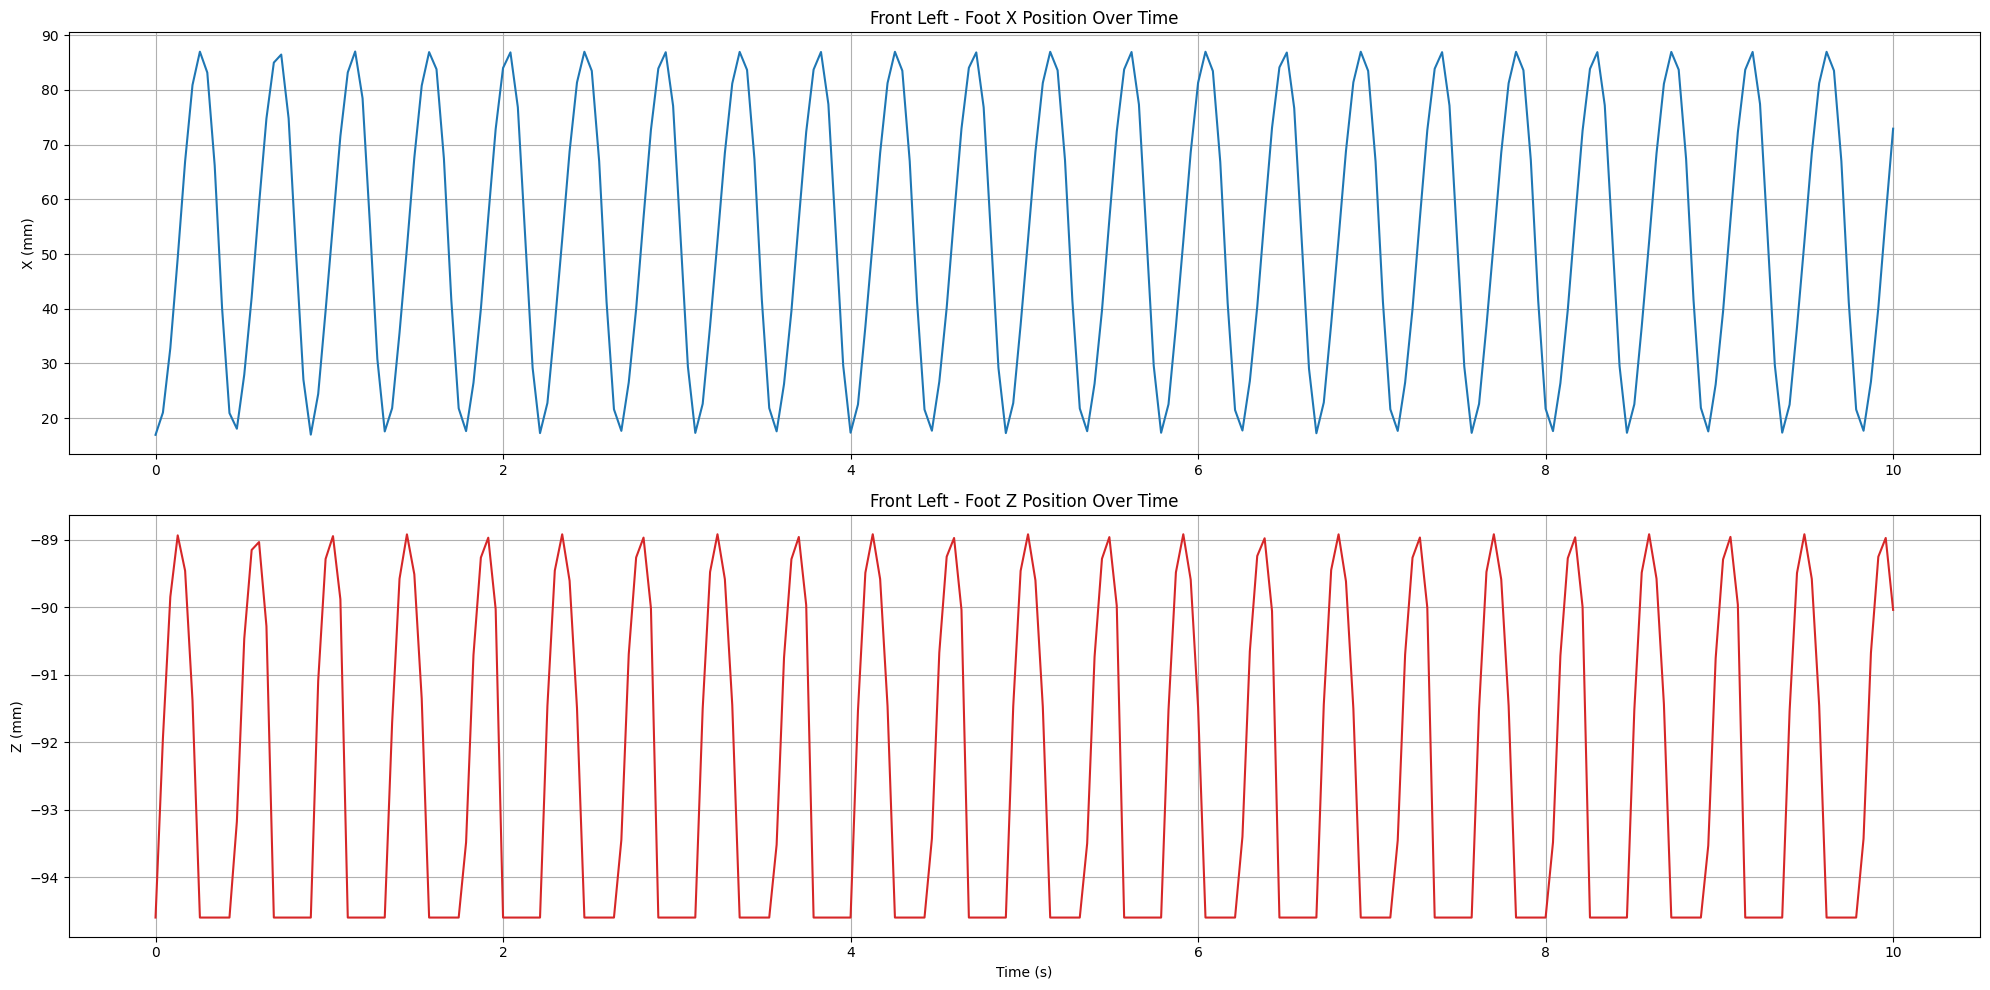

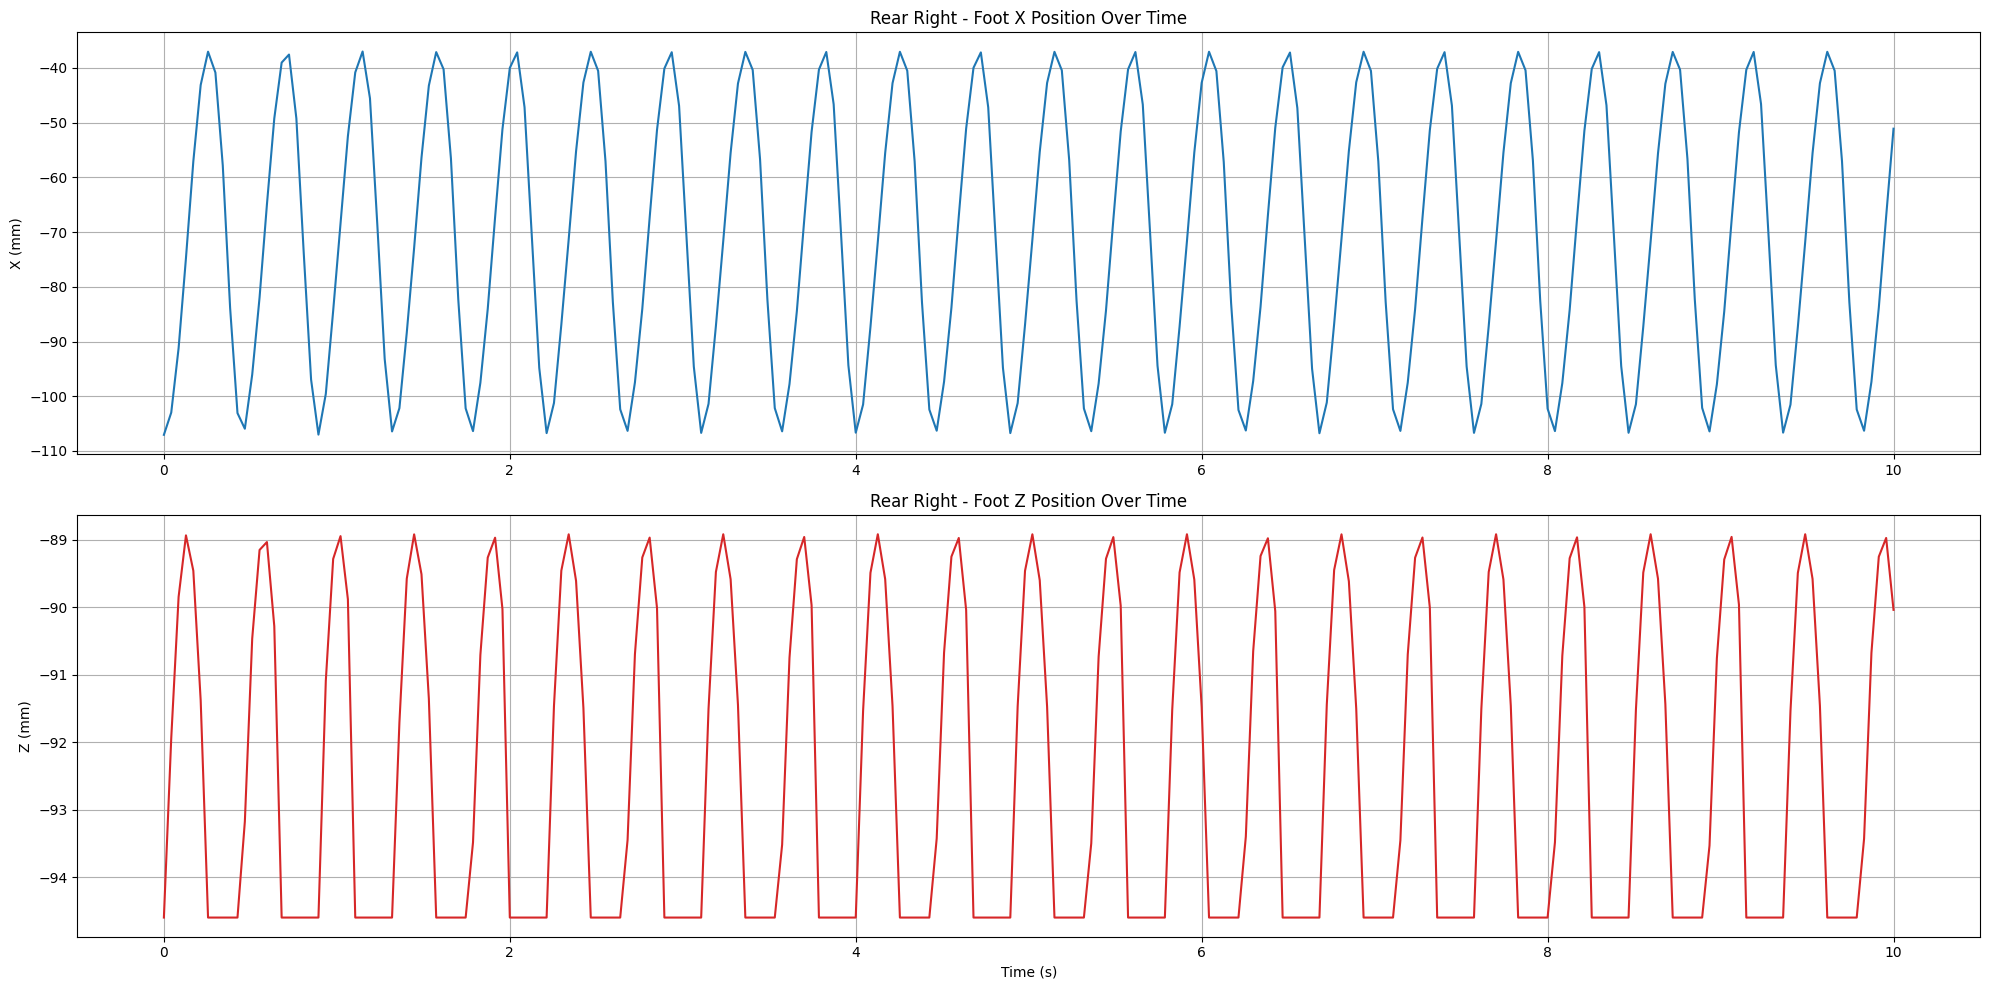

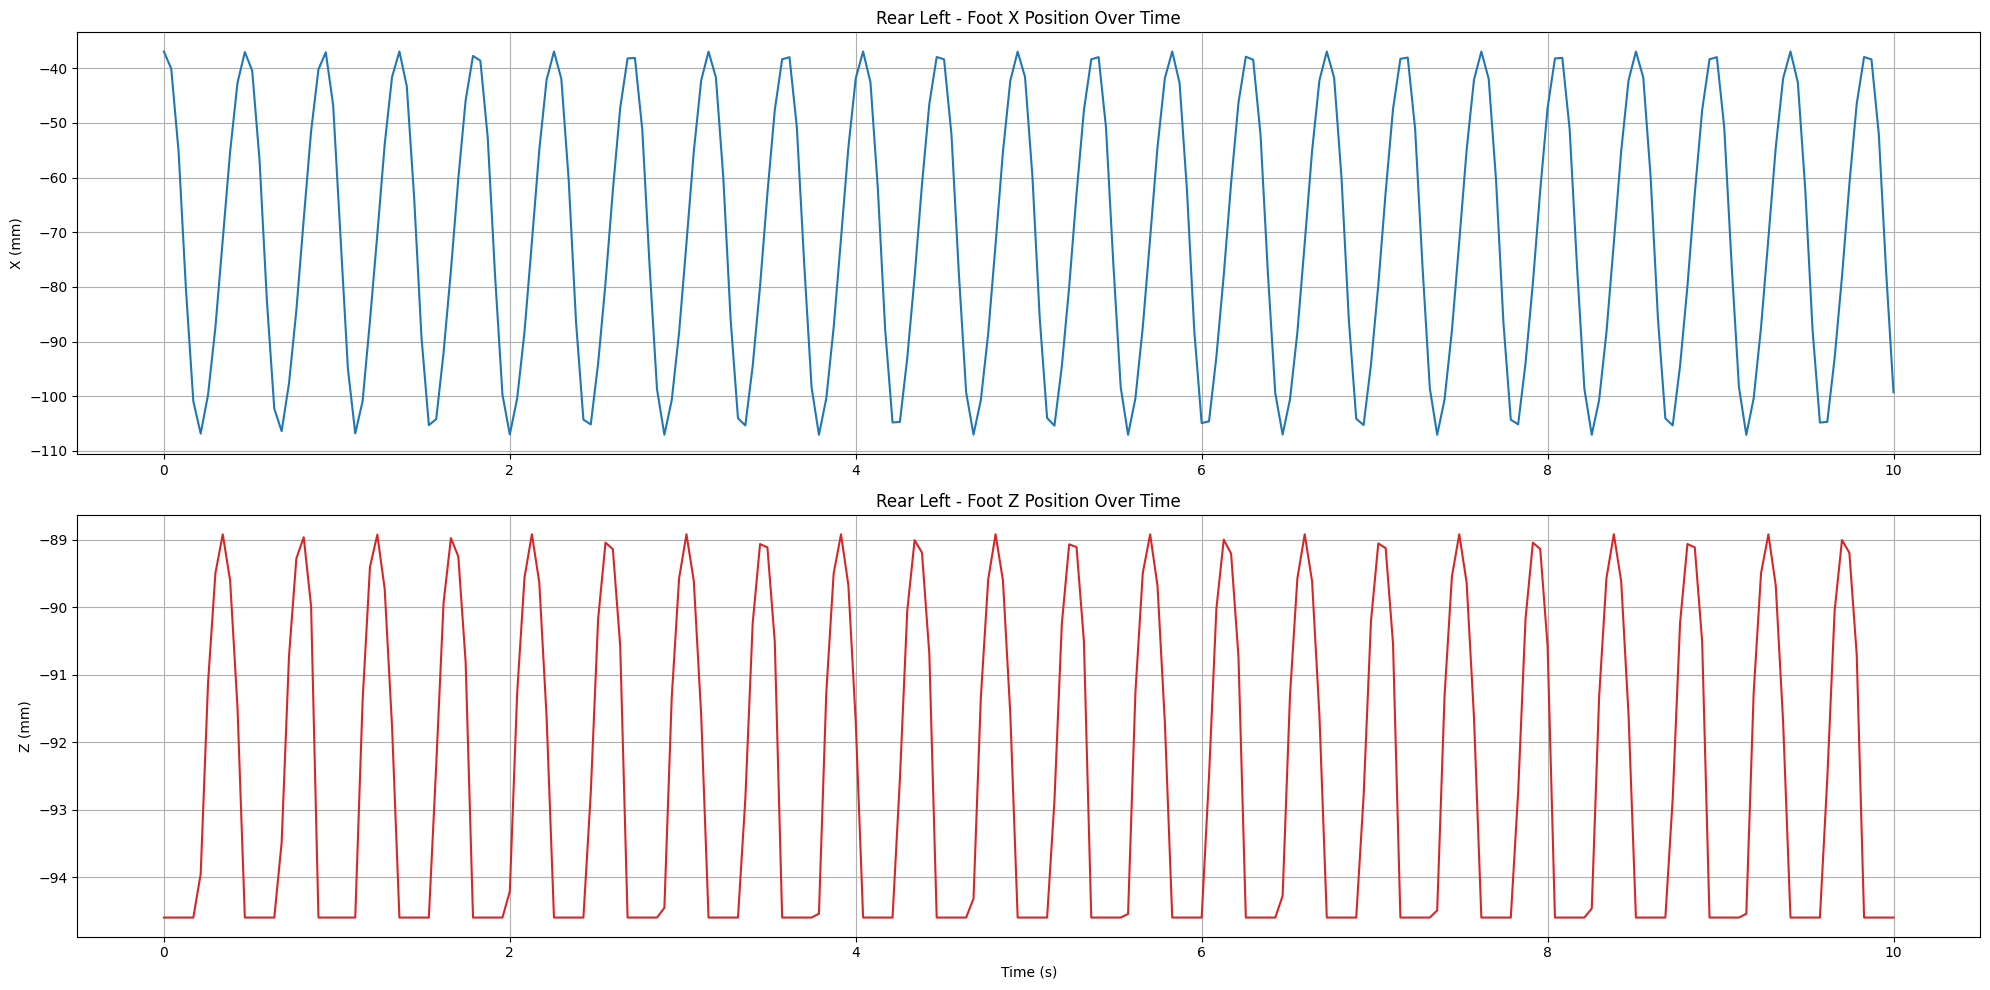

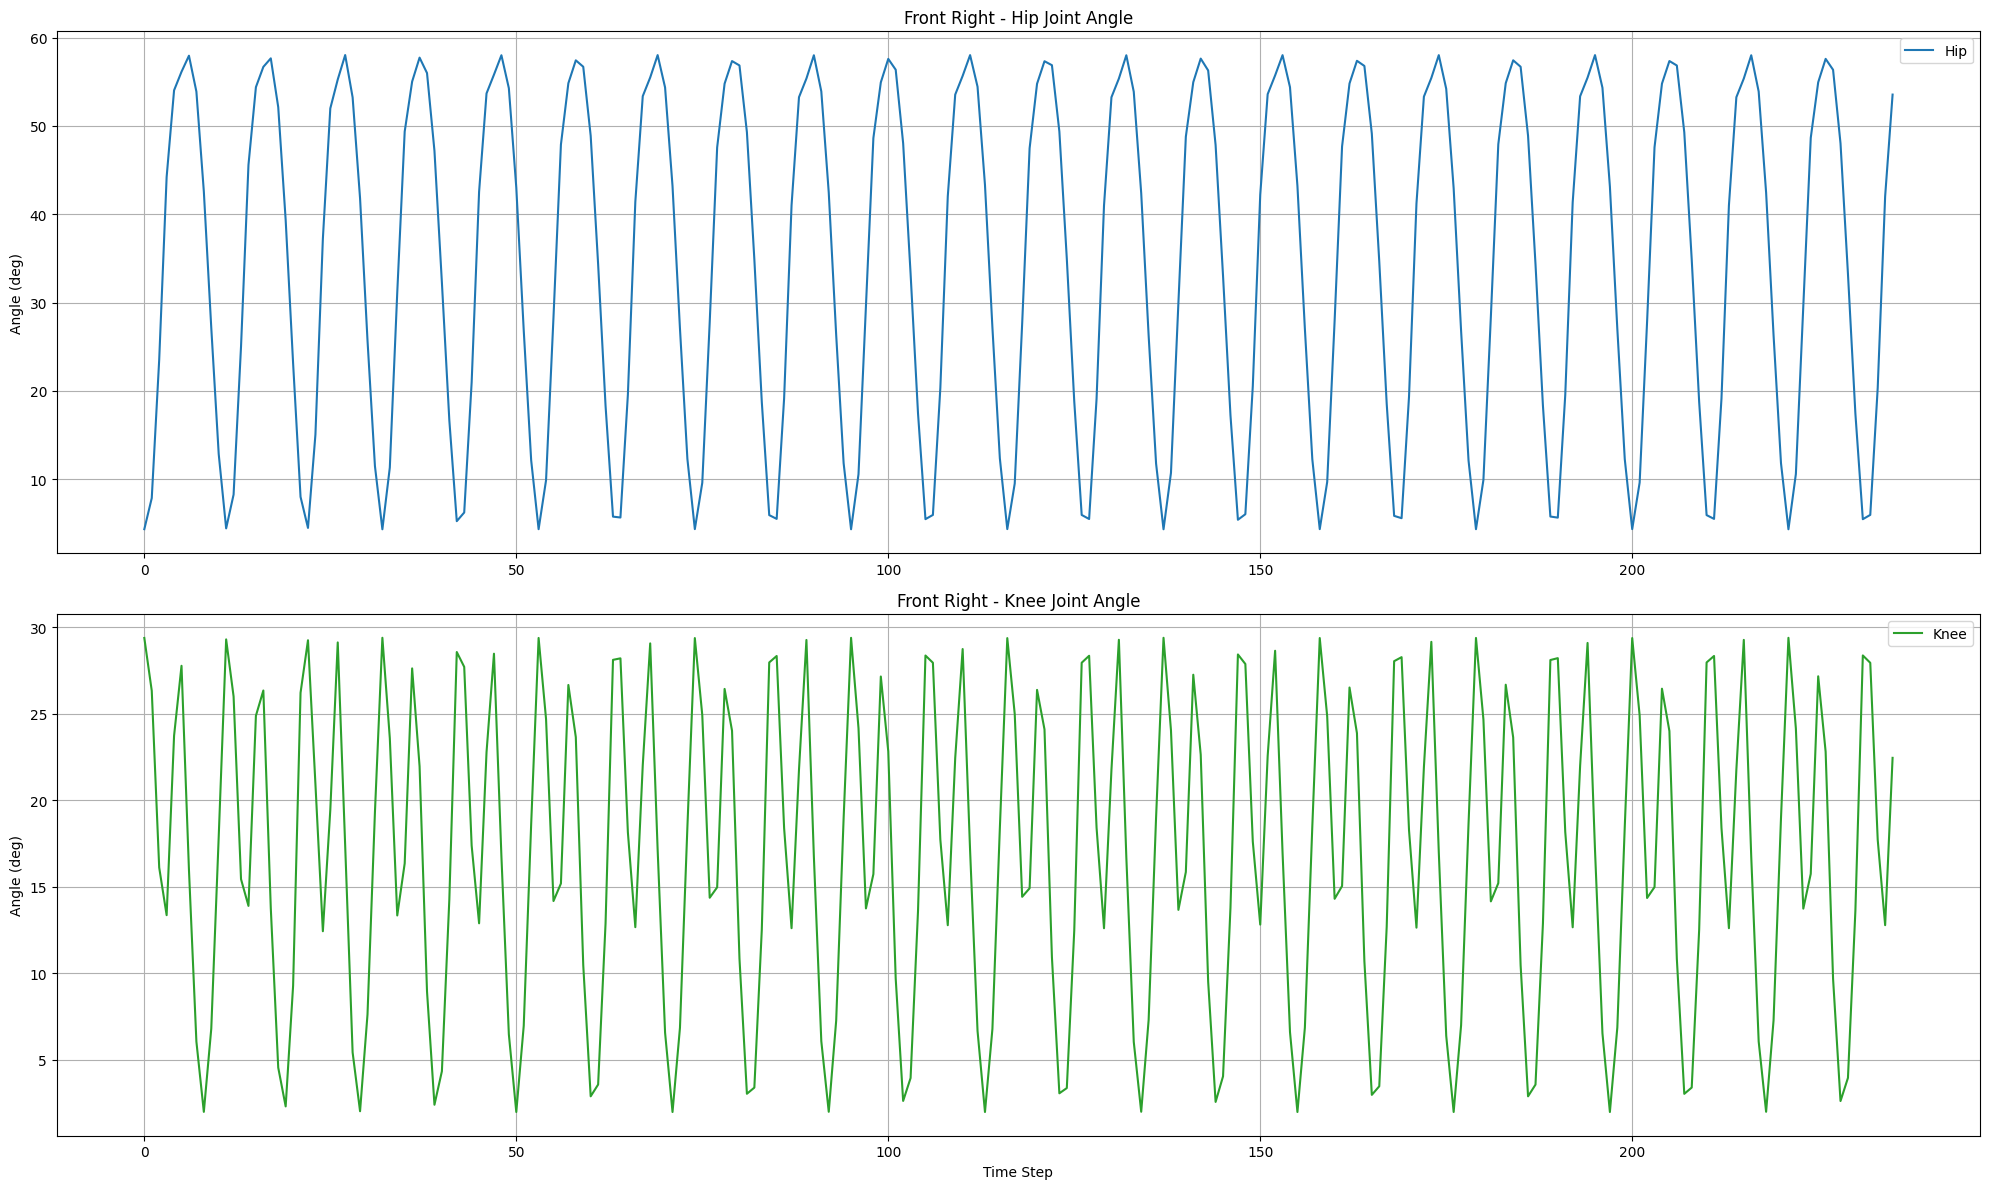

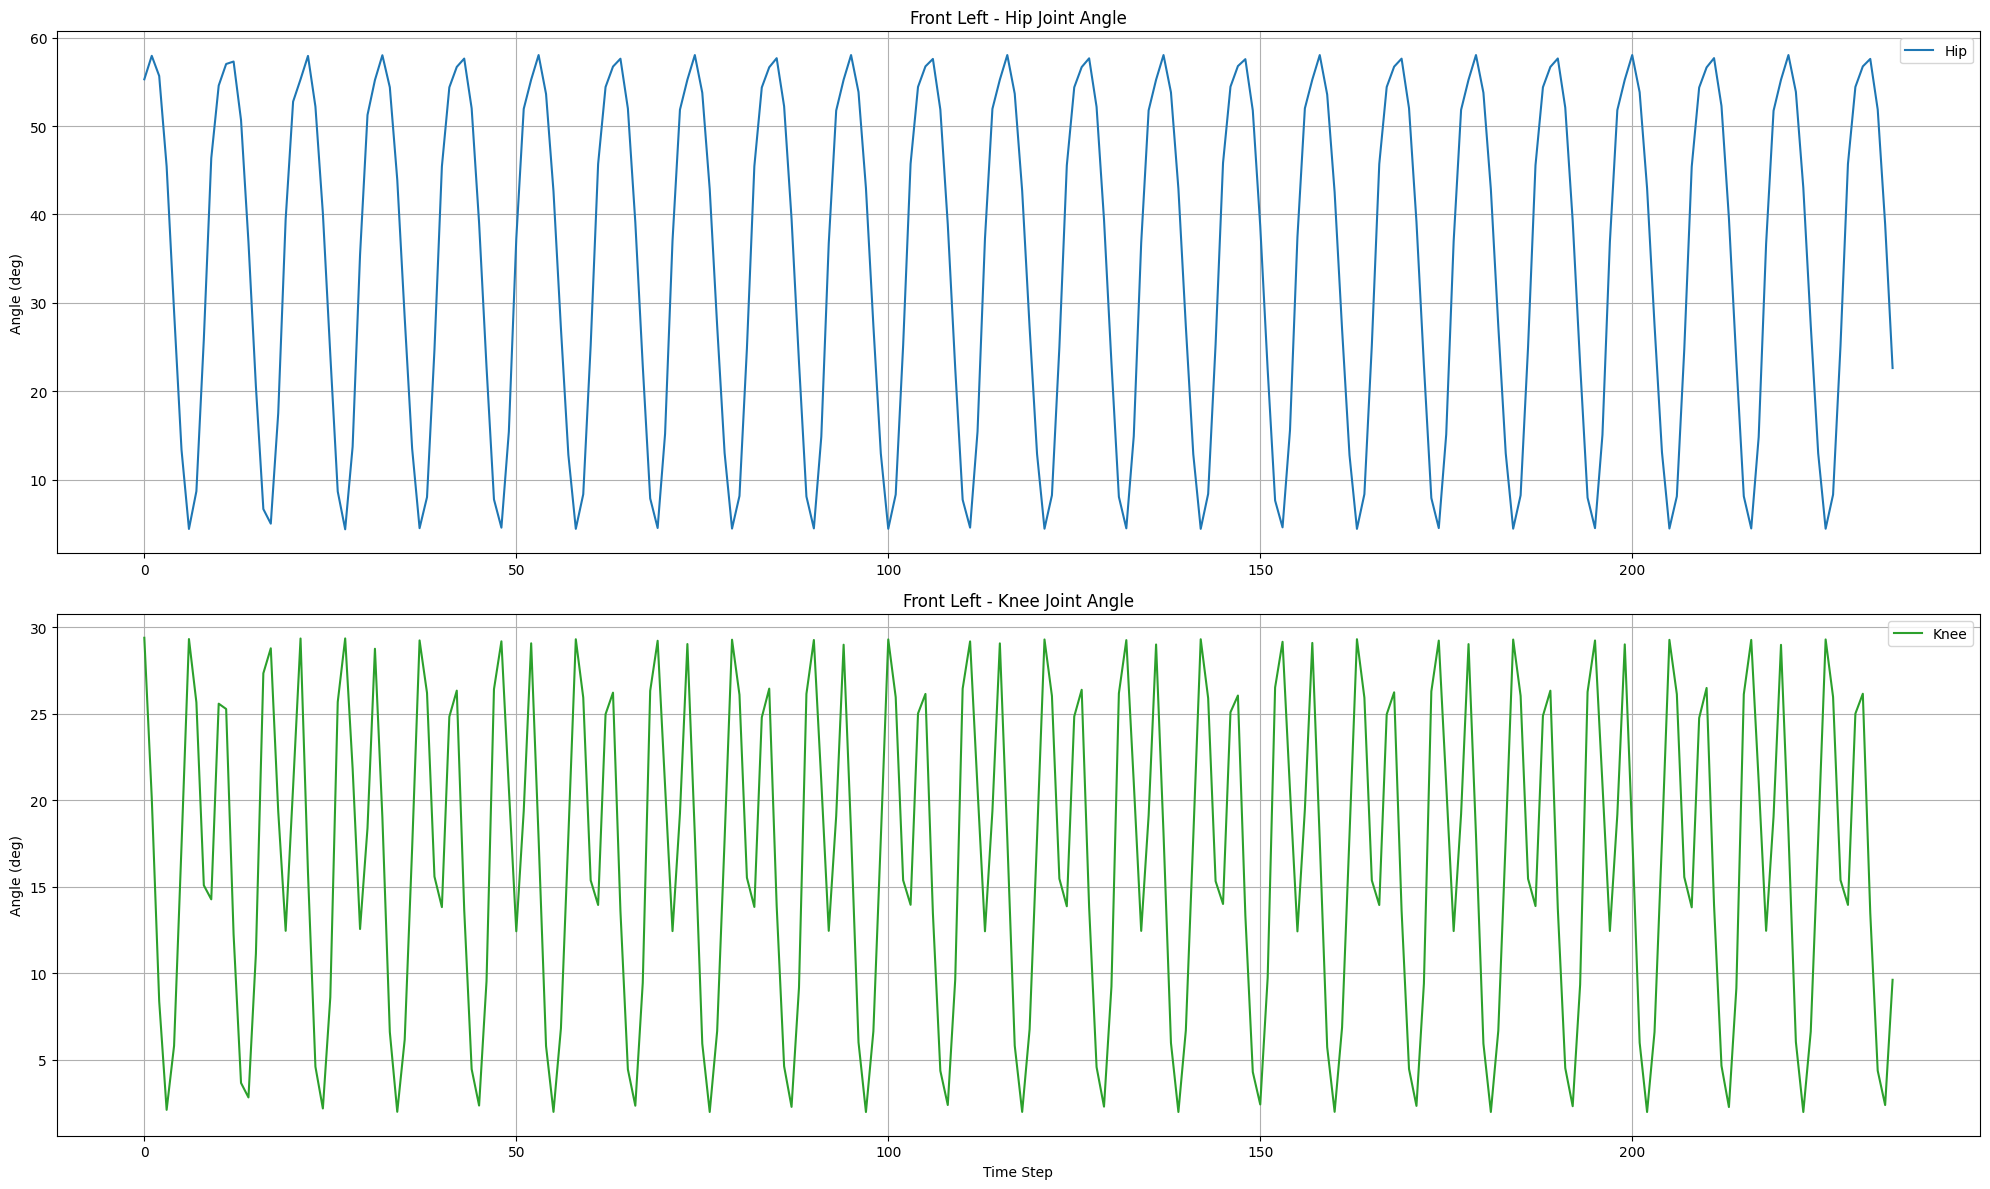

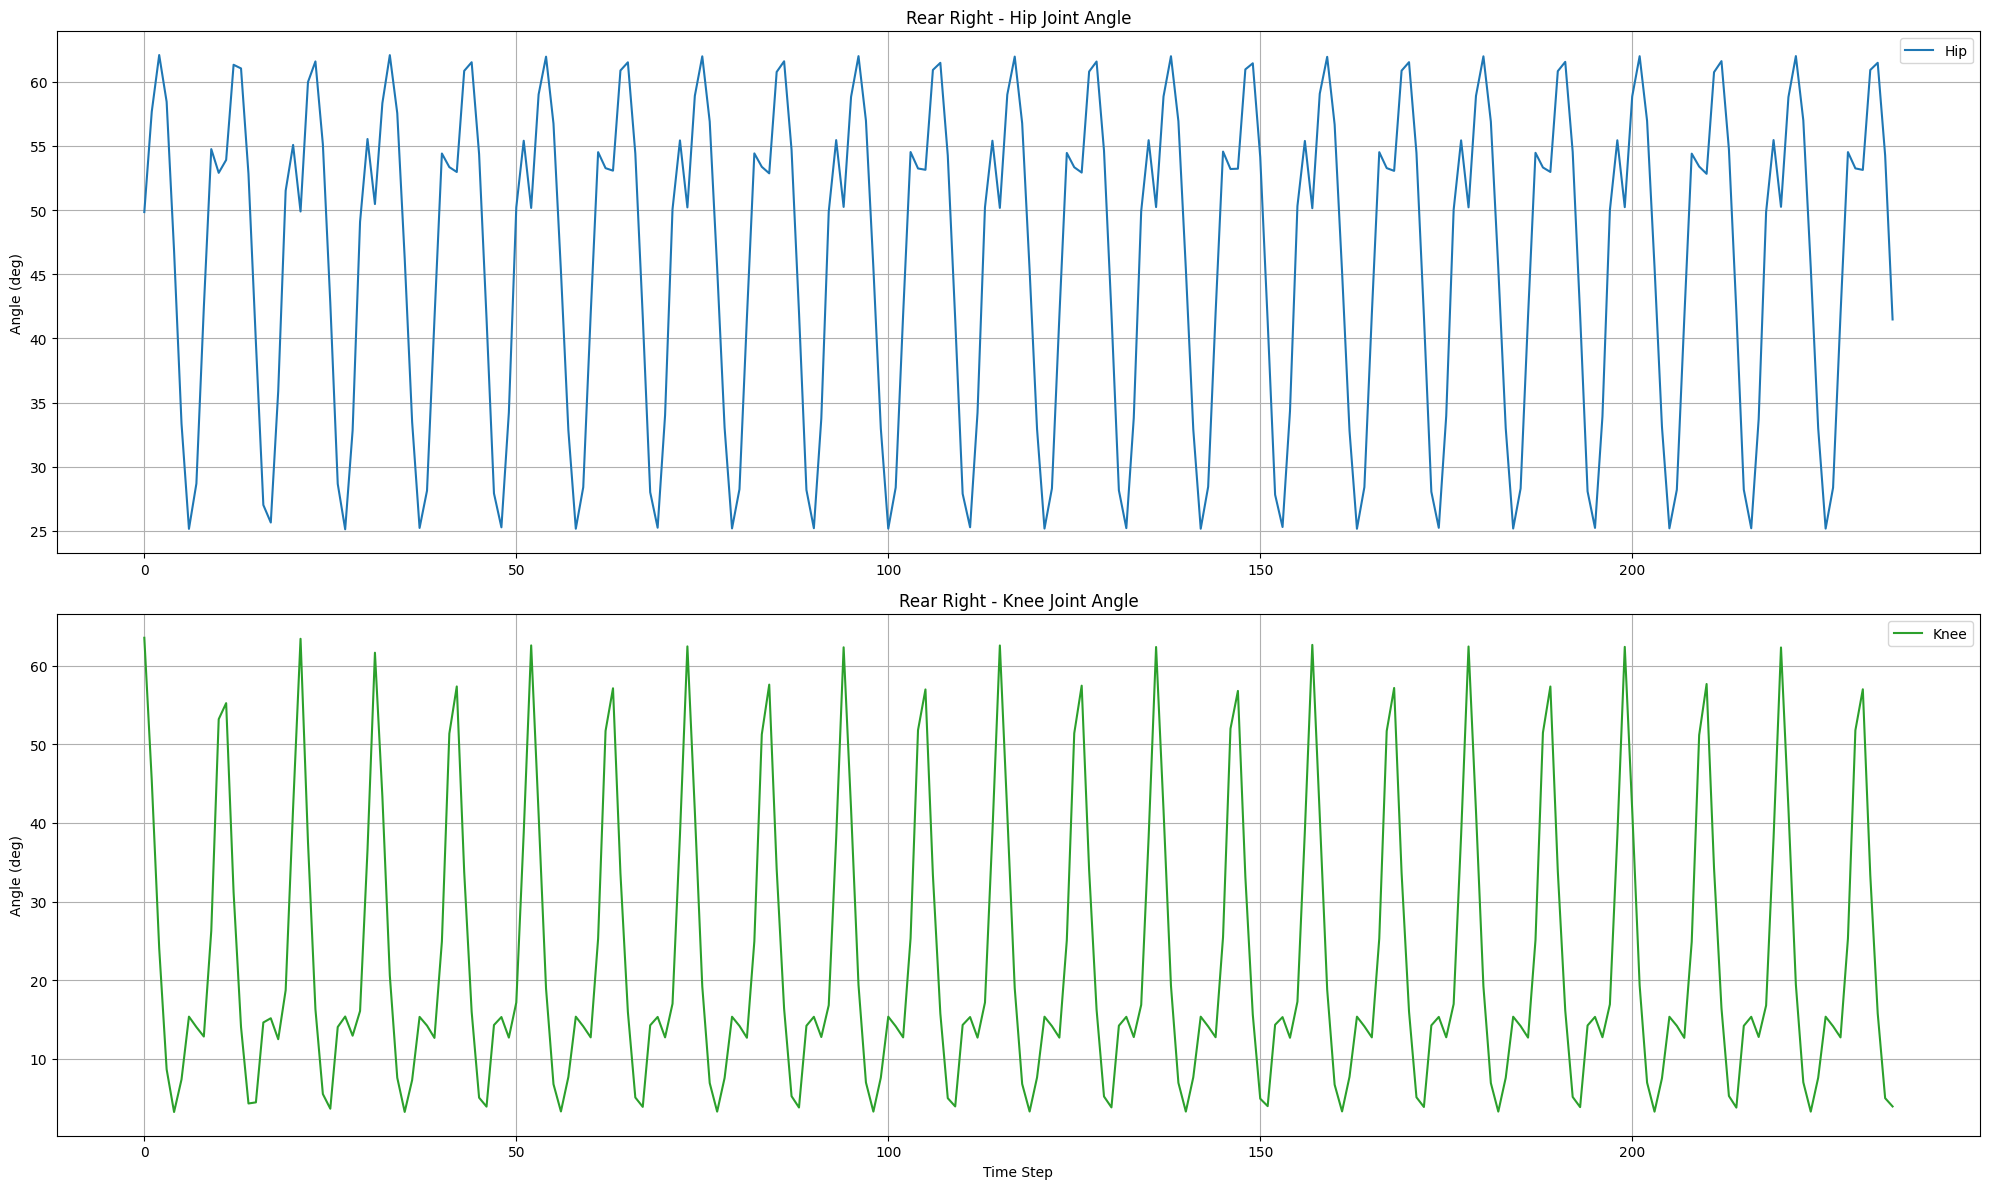

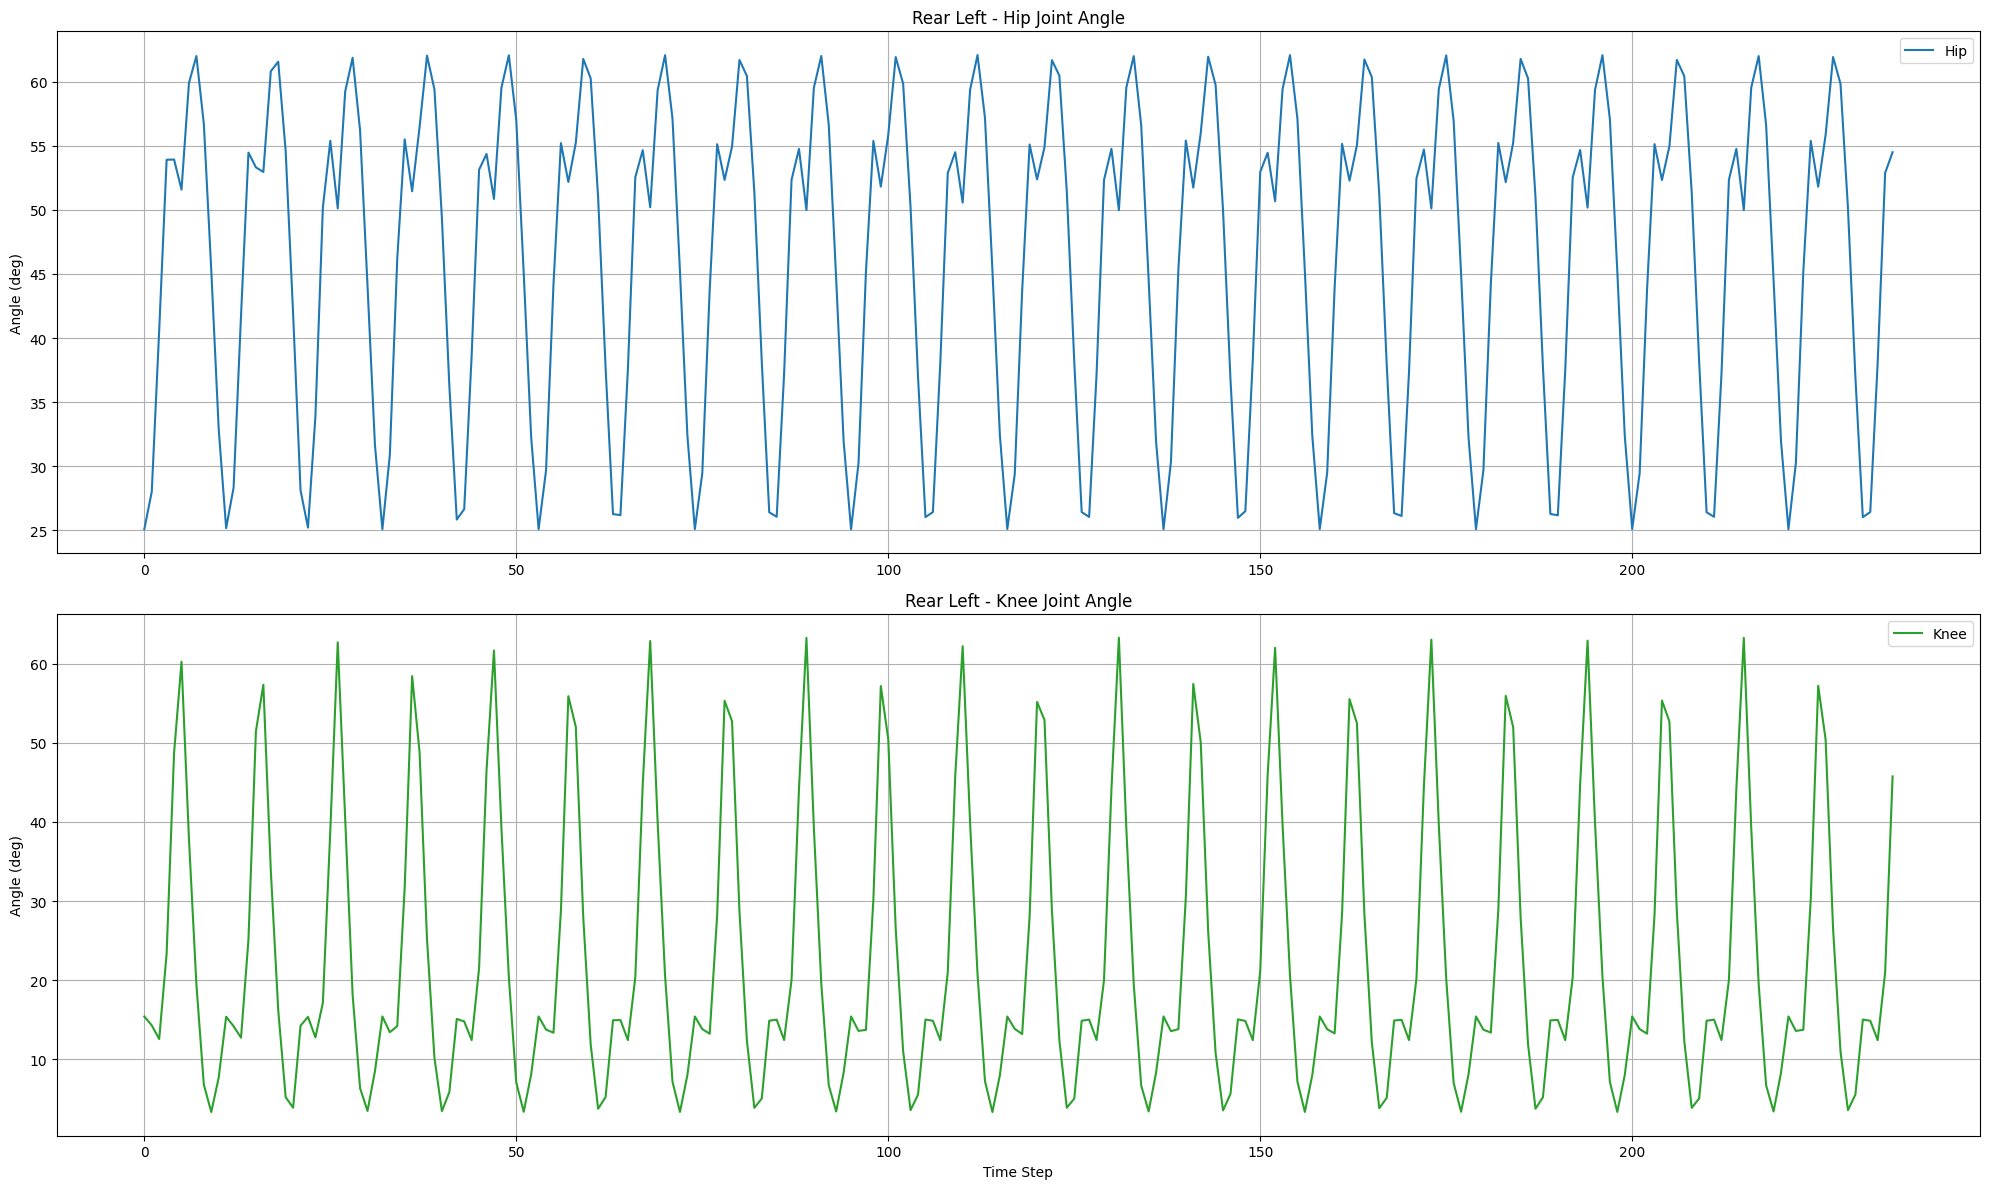

In [ ]:
# testing validation and verification module for the integrated envrionment, also provides a sample to how the code should be used


import numpy as np
import matplotlib.pyplot as plt
from Bittle_locomotion import hopf_cpg_dot, connectionwieghtmatrixR,MotionPlanning,gaitParams
from inversegait import JointOffsets, hiplength, kneelength


# === Time Setup ===
time = np.linspace(0, 10, 236)  # time in seconds
dt = time[1] - time[0] #interval 

# === Gait setup ===
gait = gaitParams(S=70.1, H=5.678, x_COMshift=-20, robotheight=20, dutycycle=0.5815)
trot_phase_difference = np.array([0.496, 0, 0, 0.496]) * 2 * np.pi
R_trot = connectionwieghtmatrixR(trot_phase_difference)

# === Initial Hopf oscillator state Q ===
Q = np.zeros(8)
for i in range(4):
    Q[2 * i] = np.cos(trot_phase_difference[i])
    Q[2 * i + 1] = np.sin(trot_phase_difference[i])

# === Run oscillator for all time steps ===
Q_data = []
for t_idx in range(len(time)):
    Q_data.append(Q.copy())
    if t_idx < len(time) - 1:
        Q = hopf_cpg_dot(
            Q, R=R_trot, delta=0.5,
            dutycycle=gait.dutycycle, T=1/2.1,
            b=50, mu=1, alpha=10, gamma=10, dt=dt
        )
Q_data = np.array(Q_data)

# === Robot leg constants ===
L1 = hiplength  # 47.9 mm
L2 = kneelength # 46.5 mm
z_rest_foot = -68.92

LegNames = ["Front Right", "Front Left", "Rear Right", "Rear Left"]

# === Run trajectory + IK for all legs ===
foot_trajectories = {}
joint_angles = {}

for leg_index, leg_name in enumerate(LegNames):
    joint_offset = JointOffsets[leg_name]
    x_hipoffset = joint_offset["x_offset"]
    z_hipoffset = joint_offset["z_offset"]
    isRear = "Rear" in leg_name

    x_hopf = Q_data[:, 2 * leg_index]
    z_hopf = Q_data[:, 2 * leg_index + 1]

    mp = MotionPlanning(
        gait_pattern=gait,
        x_hipoffset=x_hipoffset,
        z_hipoffset=z_hipoffset,
        isRear=isRear,
        L1=L1,
        L2=L2,
        z_rest_foot=z_rest_foot
    )

    X_traj, Z_traj = mp.TrajectoryGenerator(x_hopf, z_hopf)
    theta_hip, theta_knee = mp.InverseKinematics(X_traj, Z_traj)

    foot_trajectories[leg_name] = (X_traj, Z_traj)
    joint_angles[leg_name] = (theta_hip, theta_knee)

# # === Plot all trajectories ===
# plt.figure(figsize=(10, 8))
# for leg_name in LegNames:
#     X, Z = foot_trajectories[leg_name]
#     plt.plot(X, Z, label=leg_name)
# plt.title("Foot Trajectories (Trot Gait)")
# plt.xlabel("X (mm)")
# plt.ylabel("Z (mm)")
# plt.legend()
# plt.gca().invert_yaxis()
# plt.grid(True)
# plt.show()


# === Plot foot positions (X and Z) against time ===
for leg_name in LegNames:
    X, Z = foot_trajectories[leg_name]

    plt.figure(figsize=(20, 10))

    # === Subplot 1: X Position vs. Time ===
    plt.subplot(2, 1, 1)
    plt.plot(time, X, label='X Position', color='tab:blue')
    plt.title(f"{leg_name} - Foot X Position Over Time")
    plt.ylabel("X (mm)")
    plt.grid(True)

    # === Subplot 2: Z Position vs. Time ===
    plt.subplot(2, 1, 2)
    plt.plot(time, Z, label='Z Position', color='tab:red')
    plt.title(f"{leg_name} - Foot Z Position Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Z (mm)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# # === Plot joint angles for each leg ===
# fig, axs = plt.subplots(4, 1, figsize=(12, 20), sharex=True)
# for i, leg_name in enumerate(LegNames):
#     hip, knee = joint_angles[leg_name]
#     axs[i].plot(np.degrees(hip), label="Hip")
#     axs[i].plot(np.degrees(knee), label="Knee")
#     axs[i].set_title(f"Joint Angles - {leg_name}")
#     axs[i].set_ylabel("Angle (deg)")
#     axs[i].legend()
# plt.xlabel("Time Step")
# plt.tight_layout()
# plt.show()

# # === Plot joint angles for each leg ===
for leg_name in LegNames:
    hip, knee = joint_angles[leg_name]

    plt.figure(figsize=(20, 12))

    # Subplot 1: Hip angle
    plt.subplot(2, 1, 1)
    plt.plot(np.degrees(hip), label="Hip", color="tab:blue")
    plt.title(f"{leg_name} - Hip Joint Angle")
    plt.ylabel("Angle (deg)")
    plt.grid(True)
    plt.legend()

    # Subplot 2: Knee angle
    plt.subplot(2, 1, 2)
    plt.plot(np.degrees(knee), label="Knee", color="tab:green")
    plt.title(f"{leg_name} - Knee Joint Angle")
    plt.xlabel("Time Step")
    plt.ylabel("Angle (deg)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()